#Cloudbakers Data Modelling Script

In [ ]:
### initalizing libraries 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, keras, itertools
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

### Authorize to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Capstone Project./Datasets')

### Read the dataset
Dataset = pd.read_csv('Dataset_RF_Activity_Score.csv')
repo_data=Dataset.loc[Dataset['repoID']==113564765]
single_repo_series=repo_data.Normalised_Activity_Score
Risk_Score=single_repo_series


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Function for Grid Search and LSTM Model Building

def GridSearch(series, params_grid):
    """
    Runs a grid search over specified parameter ranges
    Args:
        series: the time series of interest
        params_grid: a dictionary specifying parameters
                    {input_size, hidden_units, dropout,
                    learning_rate, n_ahead, val_split,
                    epochs, verbose, plot} and their
                    possible value ranges
    Returns:
        model: the model with the lowest MSE
        logs: logs of all combinations

    """
    param_names = list(params_grid.keys())
    param_values = list(params_grid.values()) 
    combinations = list(itertools.product(*param_values))
    
    logs = pd.DataFrame(combinations,columns=param_names)
    
    mse_prev = 50
    for index, comb in enumerate(combinations):
        print('Fitting {}/{} model'.format(index+1,len(combinations)))
        params = dict(zip(param_names,comb))
        model, mse, history, predn, y_test = FitEvaluate(series,params) #Fit eval
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
                
        if mse < mse_prev:
            mse_prev = mse
            best_model = model              #best Model
            best_predictions = predn
            yt = y_test
        
        logs.at[index,'mse'] = mse
        logs.at[index,'mean_training_loss'] = np.mean(train_loss)
        logs.at[index,'std_training_loss'] = np.std(train_loss)
        logs.at[index,'mean_val_loss'] = np.mean(val_loss)
        logs.at[index,'std_val_loss'] = np.std(val_loss)
    logs.to_csv('results.csv',index=False)
    # view_predictions(series,best_predictions,y_test,'Actual vs Forecast')
    return best_model, logs, best_predictions, yt

def FitEvaluate(time_series, params):
    """
    Calls the pipeline to fit an LSTM model to the
    given time series

    Args:
        time_series: the time series of interest
        params: a dictionary specifying parameters
                {input_size, hidden_units, dropout,
                learning_rate, n_ahead, val_split,
                epochs, verbose, plot}
    Returns:
        model: keras sequential model
        mse: mean squared error of the prediction
        history: training and validation loss history

    """
    for k in params.keys():
        globals()[k] = params[k]
        
    scaled_series, scaler = preprocessing(time_series) 
    series, y_test, n_test = getSeries(scaled_series,0.8)
    X_train,y_train,X_test = getInputOutput(series,input_size)
    
    # show only n_ahead number of actual values
    y_test = y_test[np.arange(n_ahead)]

    new_model, predictions, history = FitForecast(X_train,y_train,X_test,n_ahead,
                                        input_size,hidden_units,dropout, val_split,
                                        learning_rate,epochs,trained_model=None)
    
    # rescaling
    series = inverse_transform(series, scaler)
    y_test = inverse_transform(y_test, scaler)
    predictions = inverse_transform(predictions, scaler)

    mse = mean_squared_error(y_true=y_test,y_pred=predictions)
    
    #if verbose:
     # print('\n')
      #print('======== Prediction Evaluation =========')
      #print('MSE is {}'.format(mse))
        
    #if plot:
     # ViewLoss(history)
      #view_predictions(series,predictions,y_test,'Actual vs Forecast')
    return new_model, mse, history, predictions, y_test


def preprocessing(series):
    """
    MinMax Scaling of the raw time series
    Args:
        series: the raw time series
    Returns:
        scaled_series and scaler object
    """
    series = np.array(series)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(series.reshape(-1, 1))
    scaled_series = scaled.reshape((len(series),))
    return (
     scaled_series, scaler)


def getSeries(data, p):
    """
    Splits a given time series proportionally
    for training and testing purposes

    Args:
        data: numpy array or pandas series
              containing the time series.
        p: float value that defines the
           proportion of the series used
           for training.
    Returns:
        series: time series for training
        y_test: time series for testing
        n_test: number of timesteps
                in the test series

    """
    n = data.shape[0]
    n_train = int(n * p)
    n_test = n - n_train
    x = np.arange(n)
    index_train = x[:n_train]
    index_test = x[n_train:]
    series = data[index_train]
    y_test = data[index_test]
    return (series, y_test, n_test)



def getInputOutput(series, input_size):
    """
    Transforms the time series into desired
    shape to be able to pass to the network

    Args:
        series: the time series.
        input_size: int that defines the length
                    of the input sequence to be
                    fed to the network
    Returns:
        X_train: input dataset
        y_train: output values
        X_test: the last available sequence

    """
    series = np.array(series)
    xlen = len(series)
    xrows = xlen - input_size
    X_train, y_train = [], []
    for i in range(xrows):
        j = i + input_size
        a = series[i:j, np.newaxis]
        X_train.append(a)
        y_train.append(series[j])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test = series[xrows:].reshape(1, input_size, 1)
    return (
     X_train, y_train, X_test)
    


def FitForecast(X_train, y_train, X_test, n_ahead, input_size, hidden_units, dropout, val_split, learning_rate, epochs, trained_model):
    """
    Fits a model and returns the predicted values.
    Optionally weights from another network can be passed

    Args:
        X_train: input dataset for training
        y_train: output dataset for training
        X_test: the last available sequence
        n_ahead: number of predictions to make
        time_series: the time series of interest
        input_size: int that defines the length
                    of the input sequence to be
                    fed to the network
        hidden_units: int/list specifying the number
                      of hidden units in the hidden
                      layer/layers
        dropout: boolean specifing whether to add dropout
                 with 0.5 rate per layer
        learning_rate: learning rate of the Adam
                       optimization algorithm
        epochs: int that defines the number of
                training phases through the
                training dataset
        trained_model: already trained keras sequential
                       model

    Returns:
        model: keras sequential model
        predictions: numpy array containing the predicted values
        history: training and validation loss history

    """
    model = build_LSTM(input_size,hidden_units,dropout, learning_rate)
    
    if trained_model is not None:
        model.set_weights(weights = trained_model.get_weights())        
    
    
    history = model.fit(x=X_train, y=y_train, 
                batch_size=1, epochs=epochs, 
                verbose=1, validation_split=val_split,
                shuffle=False)

    predictions = predict_ahead(model,X_test,n_ahead)
    return model, predictions, history



def build_LSTM(input_size, hidden_units, dropout, learning_rate):
    """
    Builds the Network with LSTM hidden layers

    Args:
        input_size: int that defines the length
                    of the input sequence to be
                    fed to the network
        hidden_units: int/list specifying the number
                      of hidden units in the hidden
                      layer/layers
        dropout: boolean specifing whether to add dropout
                 with 0.5 rate per layer
        learning_rate: learning rate of the Adam
                       optimization algorithm
    Returns:
        model: keras sequential model

    """
    h = hidden_units
    

    model = Sequential()
    
    if isinstance(h,list):
    
        model.add(LSTM(h[0],
                   batch_input_shape=(1,input_size, 1), 
                   return_sequences=True, 
                   stateful=True))
                  
        if dropout:
            model.add(Dropout(rate=0.5))

        if len(h) > 2:
            #removing 1st and last units
            for index, units in enumerate(h[1:-1]):  
                model.add(LSTM(units, 
                               batch_input_shape=(1,h[index], 1), 
                               return_sequences=True, 
                               stateful=True)) 
                if dropout:
                    model.add(Dropout(rate=0.5))

        model.add(LSTM(h[-1], 
                       batch_input_shape=(1,h[-2], 1), 
                       return_sequences=False, 
                       stateful=True))
        if dropout:
            model.add(Dropout(rate=0.5))
    else:
        model.add(LSTM(h, 
                   batch_input_shape=(1,input_size, 1),
                   return_sequences=False, 
                   stateful=True)) 
        if dropout:
            model.add(Dropout(rate=0.5))
        
    
    model.add(Dense(1))
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=adam)
    return model



def predict_ahead(model, X_test, n_ahead):
    """
    Makes predictions based on the last available sequence

    Args:
        model: keras sequential model
        X_test: the last available sequence
        n_ahead: number of predictions to make

    Returns:
        predictions: numpy array containing the predicted values

    """
    predictions = np.zeros(n_ahead)
    predictions[0] = model.predict(X_test,batch_size = 1)
    
    if n_ahead > 1:
        for i in range(1,n_ahead):
            x_new = np.append(X_test[0][1:],predictions[i-1])
            X_test = x_new.reshape(1,x_new.shape[0],1)
            predictions[i] = model.predict(X_test,batch_size = 1)
    return predictions



def inverse_transform(series, scaler):
    """
    Inverse transform of scales series
    Args:
        series: scaled series
        scaler: scaler object
    Returns:
        unscaled series
    """
    return scaler.inverse_transform(series.reshape(-1, 1))



def ViewLoss(history):
    '''
    Plots the history of model training
    '''
    plt.plot(history.history['loss'],label='Train')
    plt.plot(history.history['val_loss'],label='Val')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('loss-history.png')
    plt.show()


def view_predictions(series,predictions,actual,title):
    '''
    Plots the results of the predictions made by the model
    
    Args:
        series: the time series used for training the network
        predictions: numpy array containing the predicted values
        actual: the actual time series not seen by the network
        title: the title of the plot
        
    Returns:
        plot        
        
    '''  
    
    plt.figure(figsize=(8,4))
    plt.title(title)
    
    if isinstance(series,list):
        train_index = np.arange(len(series[0]))
        test_index = len(series[0]) + np.arange(len(actual))
        
        plt.plot(train_index,series[0], label = 'general')
        
    else:
        train_index = np.arange(len(series))
        test_index = len(series) + np.arange(len(actual))        
        plt.plot(train_index,series,label = 'training')

    if len(predictions) > 4:
        plt.plot(test_index,predictions,label = 'prediction',color='g')
        plt.plot(test_index,actual,label = 'actual',color='orange')
    else:
        plt.scatter(test_index,predictions,label = 'prediction',color='g')
        plt.scatter(test_index,actual,label = 'actual',color='orange')    
    
    plt.xlabel('Index')
    plt.ylabel('Data')
    
    plt.legend(loc='upper left')
    plt.savefig('{}_{}.png'.format(title,len(series)))
    plt.show()



def Test_FitEvaluate(time_series,params,model_):
    '''
    Calls the pipeline to fit an LSTM model to the 
    given time series
    
    Args:
        time_series: the time series of interest
        params: a dictionary specifying parameters
                {input_size, hidden_units, dropout,
                learning_rate, n_ahead, val_split, 
                epochs, verbose, plot}
    Returns:
        model: keras sequential model      
        mse: mean squared error of the prediction
        history: training and validation loss history
        
    '''   
    
    for k in params.keys():
        globals()[k] = params[k]
    
    
    scaled_series, scaler = preprocessing(time_series)
    series, y_test, n_test = getSeries(scaled_series,0.8)
    X_train,y_train,X_test = getInputOutput(series,input_size)
    
    # show only n_ahead number of actual values
    y_test = y_test[np.arange(n_ahead)]

    new_model, predictions, history = FitForecast(X_train,y_train,X_test,n_ahead,
                                        input_size,hidden_units,dropout, val_split,
                                        learning_rate,epochs,trained_model=model_)
    # rescaling
    series = inverse_transform(series, scaler)
    y_test = inverse_transform(y_test, scaler)
    predictions = inverse_transform(predictions, scaler)
    
    mse = mean_squared_error(y_true=y_test,y_pred=predictions)
    
    #print('MSE is {}'.format(mse))
     
    #ViewLoss(history)
    #view_predictions(series,predictions,y_test,'Actual vs Forecast')
    return new_model, mse, history, predictions, y_test

In [ ]:
### Initialize parameters for Grid Search
params_grid = {'input_size': [15, 20, 25, 50],
              'hidden_units':[100, [100,50,50], [100,50]],
              'dropout': [True],
              'learning_rate':[4e-5],
              'n_ahead':[12],
              'val_split': [0.2],
              'epochs':[20],
              'verbose':[False],
              'plot':[False]}


#### Training the model using Grid Search
model_, logs, best_predictions, y_test = GridSearch(Risk_Score,params_grid)

Fitting 1/12 model
Epoch 1/20
54/54 [==============================] - 2s 17ms/step - loss: 0.1105 - val_loss: 0.0400
Epoch 2/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0811 - val_loss: 0.0338
Epoch 3/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0671 - val_loss: 0.0301
Epoch 4/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0516 - val_loss: 0.0289
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 0.0433 - val_loss: 0.0297
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 0.0416 - val_loss: 0.0314
Epoch 7/20
54/54 [==============================] - 0s 8ms/step - loss: 0.0459 - val_loss: 0.0325
Epoch 8/20
54/54 [==============================] - 0s 7ms/step - loss: 0.0369 - val_loss: 0.0340
Epoch 9/20
54/54 [==============================] - 0s 7ms/step - loss: 0.0422 - val_loss: 0.0338
Epoch 10/20
54/54 [==============================] - 0s 7ms/step - loss: 0.0415 - val_loss: 0.0339

In [ ]:
###Choose the bets model and retrain with the best parameters.

params_grid = {'input_size': [20],
              'hidden_units':[100],
              'dropout': [True],
              'learning_rate':[4e-5],
              'n_ahead':[12],
              'val_split': [0.2],
              'epochs':[20],
              'verbose':[False],
              'plot':[False]}


#Re-Training the model using the best parameters
model_, logs, best_predictions, y_test = GridSearch(Risk_Score,params_grid)

Fitting 1/1 model
Epoch 1/20
50/50 [==============================] - 2s 19ms/step - loss: 0.0419 - val_loss: 0.0343
Epoch 2/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0378 - val_loss: 0.0306
Epoch 3/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0312 - val_loss: 0.0290
Epoch 4/20
50/50 [==============================] - 0s 10ms/step - loss: 0.0306 - val_loss: 0.0289
Epoch 5/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0254 - val_loss: 0.0294
Epoch 6/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0368 - val_loss: 0.0294
Epoch 7/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0328 - val_loss: 0.0298
Epoch 8/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0330 - val_loss: 0.0299
Epoch 9/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0299
Epoch 10/20
50/50 [==============================] - 0s 9ms/step - loss: 0.0280 - val_loss: 0.0304

In [ ]:
### Choose the best parameters for the model
params = {'input_size': 20,
          'hidden_units':100,
          'dropout': True,
          'learning_rate':4e-5,
          'n_ahead':12,
          'val_split': 0.2,
          'epochs':20,
          'verbose':False,
          'plot':False}

#### Remove repositories with less than 20 weeks of data and other erroneous repositories 
repo_list=list(Dataset['repoID'].unique())

rows=[]
for i in range(0, len(repo_list)):
  repo_data=Dataset.loc[Dataset['repoID']==repo_list[i]]
  if repo_data.shape[0]>20:
    rows.append((repo_list[i]))

remove_list=[156630873, 168234055, 163867485, 173968989, 169825932, 165114031, 121291048, 178027217, 194736160, 181737603, 194727787, 149379192, 194736246, 159751068, 193533462, 53032138, 169601732, 173919375, 170547737, 178105940, 196555066, 141831152, 172554606, 157298123, 159539290, 185833148,164036674, 164198539, 159058750, 183677088, 145325821]
res = [i for i in rows if i not in remove_list]
rows=res   #final number of repos 221.

Epoch 1/20
196/196 [==============================] - 5s 10ms/step - loss: 0.0351 - val_loss: 0.0243
Epoch 2/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0330 - val_loss: 0.0240
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0340 - val_loss: 0.0237
Epoch 4/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0342 - val_loss: 0.0237
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0330 - val_loss: 0.0238
Epoch 6/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0335 - val_loss: 0.0238
Epoch 7/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0340 - val_loss: 0.0238
Epoch 8/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0334 - val_loss: 0.0238
Epoch 9/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0332 - val_loss: 0.0238
Epoch 10/20
196/196 [==============================] - 1s 8ms/step - loss: 0.0339 - val_loss: 0.023

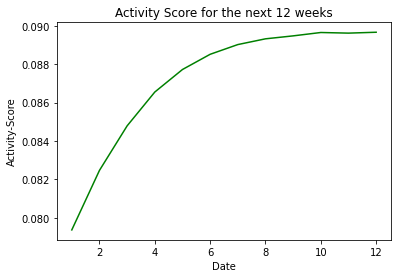

In [ ]:
#### Prediction Block

#### Input a repository ID
repo_data=Dataset.loc[Dataset['repoID']==11362691]
single_repo_series=repo_data.Normalised_Activity_Score
Risk_Score=single_repo_series

new_model_, mse, history, predictions, y_test = Test_FitEvaluate(Risk_Score, params, model_)

#### plotting predictions for next 12 weeks

Final_Score=predictions.reshape(12)
Final_Score[Final_Score<0] = 0

#### data to be plotted 
x = np.arange(start=1, stop=13, step=1)

#print(i)
#print(rows[i])
fig = plt.figure()
fig.patch.set_facecolor('white') 
plt.title("Activity Score for the next 12 weeks")  
plt.xlabel("Date")  
plt.ylabel("Activity-Score")
plt.plot(x, Final_Score, color ="green")  
plt.show()